In [6]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.polynomial.polynomial import Polynomial
from netCDF4 import Dataset
from matplotlib import cm


In [2]:
def BackgroundModel(r):
    DISCONTINUITIES = np.array([6371.0, 6151.0, 5971.0, 5771.0, 5701.0, 5600.0, 3630.0, 3480.0, 1221.5, 0.])

    RHOCoef = np.zeros((len(DISCONTINUITIES)-1,4))
    VPCoef = np.zeros((len(DISCONTINUITIES)-1,4))
    VSCoef = np.zeros((len(DISCONTINUITIES)-1,4))

    with open('./prem_iso_smooth.bm' , 'r') as f:
        lines = f.readlines()

    for iline, line in enumerate(lines):
        if line.startswith('RHO'):
            # print(line)
            for iDisc, Disc in enumerate(DISCONTINUITIES[:-1]):
                tmpread = np.fromstring(lines[iline+1+iDisc], dtype=np.float64, sep=' ')
                RHOCoef[iDisc,0:len(tmpread)] = tmpread
        if line.startswith('VP'):
            # print(line)
            for iDisc, Disc in enumerate(DISCONTINUITIES[:-1]):
                tmpread = np.fromstring(lines[iline+1+iDisc], dtype=np.float64, sep=' ')
                VPCoef[iDisc,0:len(tmpread)] = tmpread
        if line.startswith('VS'):
            # print(line)
            for iDisc, Disc in enumerate(DISCONTINUITIES[:-1]):
                tmpread = np.fromstring(lines[iline+1+iDisc], dtype=np.float64, sep=' ')
                VSCoef[iDisc,0:len(tmpread)] = tmpread

    NREGION = np.where(DISCONTINUITIES < r)[0][0] - 1
    # print(NREGION)
    RHOf = Polynomial(RHOCoef[NREGION,:])
    VPf = Polynomial(VPCoef[NREGION,:])
    VSf = Polynomial(VSCoef[NREGION,:])
    
    return (RHOf(r/6371.),VPf(r/6371.),VSf(r/6371.))

vBackgroundModel = np.vectorize(BackgroundModel)

### Cartesian Model

In [ ]:
# Load the velocity model (only confined to a small box region)
f = Dataset('../input/box_tomography.nc', 'r')

x = f['x'][:]
y = f['y'][:]
depth = f['depth'][:]

SeismicModelPtb = f['dvp'][:,:,:]                ## Generated by ,     dimensions(sizes): nlat(21), nlon(21), nradius(5)
                                                ## variables(dimensions): float64 latitude(nlat), float64 longitude(nlon), float64 radius(nradius), float64 dvs(nlat,nlon,nradius)
print(x.min(),x.max())
print(y.min(),y.max())
print(depth.min(),depth.max())
print(SeismicModelPtb.min(),SeismicModelPtb.max())

In [ ]:
from scipy.interpolate import RegularGridInterpolator

def GetVelocity(x_point,y_point,depth_point):

    # BGModel = vBackgroundModel(r_point)[1] # Get default VP model 
    BGModel = 1000.0 # uniform model
    # Out of bound use default value
    interp = RegularGridInterpolator((x, y, depth), SeismicModelPtb, bounds_error=False, fill_value=0.0) 

    return (interp([x_point, y_point, depth_point])+1)*BGModel


In [ ]:
GetVelocity(0,0,500)    # Unit is m ...

### Spherical Model

In [3]:
# Load the velocity model (only confined to a small box region)
f = Dataset('../input/box_tomography.nc', 'r')

lat = f['latitude'][:]
lon = f['longitude'][:]
r = f['radius'][:]

SeismicModelPtb = f['dvs'][:,:,:]                ## Generated by ,     dimensions(sizes): nlat(21), nlon(21), nradius(5)
                                                ## variables(dimensions): float64 latitude(nlat), float64 longitude(nlon), float64 radius(nradius), float64 dvs(nlat,nlon,nradius)
print(lat.min(),lat.max())
print(lon.min(),lon.max())
print(r.min(),r.max())
print(SeismicModelPtb.min(),SeismicModelPtb.max())

20.0 60.0
-20.0 20.0
3480.0 3880.0
-0.07633130088609127 0.07267735457342783


In [4]:
from scipy.interpolate import RegularGridInterpolator

def GetVelocity(x,y,z):
    r_point = np.sqrt(x**2+y**2+z**2)
    lat_point = 90-np.degrees(np.arctan2(np.sqrt(x**2+y**2),z))
    lon_point = np.arctan2(y,x)

    BGModel = vBackgroundModel(r_point)[1] # Get default VP model 
    # Out of bound use default value
    interp = RegularGridInterpolator((lat, lon,r), SeismicModelPtb, bounds_error=False, fill_value=0.0) 

    return (interp([lat_point, lon_point, r_point])+1)*BGModel

In [5]:
GetVelocity(3600,0,0)    # Unit is km ...

array([13.68756852])

### Plot Velocity

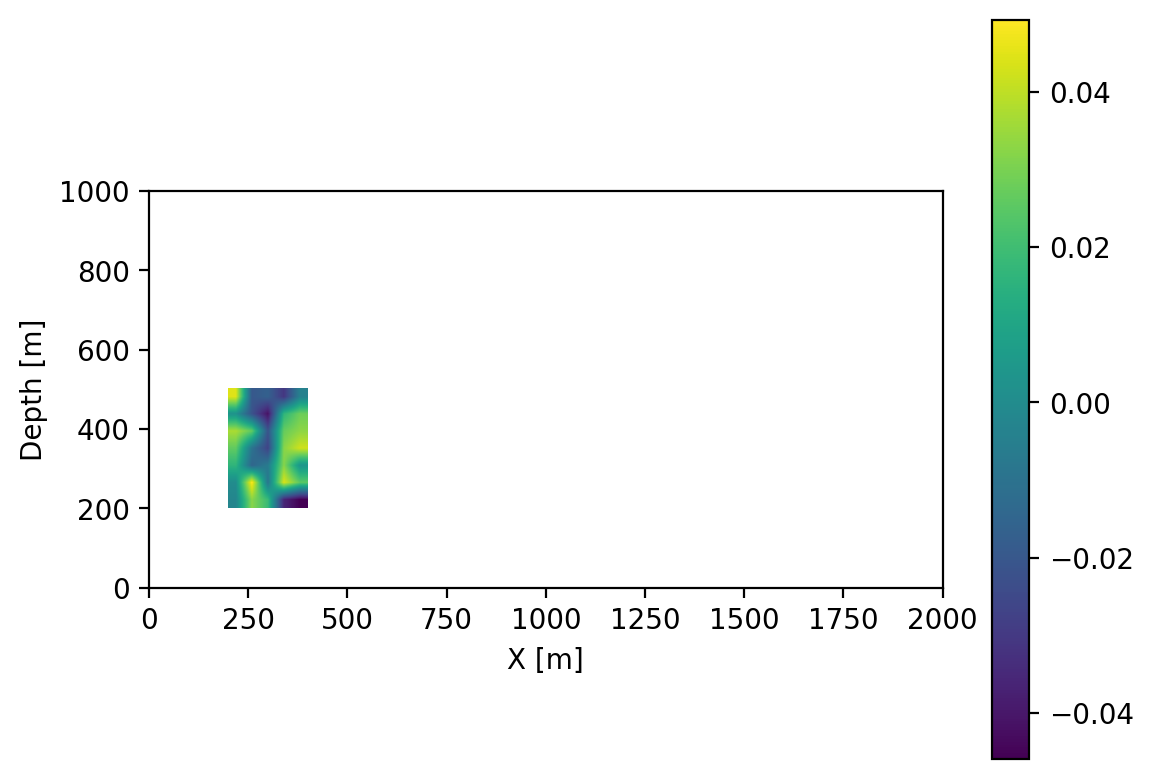

In [10]:
# Load the velocity model (only confined to a small box region)
f = Dataset('../Runs/CartesianModel0007_random0005_gaussian/input/cartesian_random_tomo.nc', 'r')

grid_x = f['x'][:]
grid_y = f['y'][:]
grid_depth = f['depth'][:]

SeismicModelPtb = f['dvp'][:,:,:]  

# Locate y=0 slice
y_index = np.where(grid_y==-2000)[0][0]

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure(dpi=200)
ax = fig.gca()
# ax = fig.gca(projection='3d')

extent = np.min(grid_x), np.max(grid_x), np.min(grid_depth), np.max(grid_depth)
PLOT = ax.imshow(SeismicModelPtb[:,y_index,:].T, cmap=cm.viridis, interpolation='bilinear', extent=extent, origin='lower')
# ax.set_aspect(1)
ax.set_xlim(0,2000)
ax.set_ylim(0,1000)

# PLOT = ax.pcolormesh(grid_x, grid_depth, MLtomo_ptb[:,y_index,:].T, cmap=cm.viridis)


ax.set_aspect(1)
ax.set_xlabel("X [m]")
ax.set_ylabel("Depth [m]")
plt.colorbar(PLOT)

# plt.savefig("IC_Scattering_plot.png", format="png")
plt.show()

In [3]:
grid_y

masked_array(data=[-2000.,  2000.],
             mask=False,
       fill_value=1e+20)